In [30]:
import random
from copy import deepcopy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

# linestyles for graphics
line_styles = [
    'solid',
    'dotted',
    'dashdot',
]

# colors for graphics
line_colors = [
    'darkgreen',
    'firebrick',
    'gold',
    'hotpink',
    'darkviolet',
    'mediumblue'
]

In [31]:
sql_query_get_avg_min = """
    with avg_minimums as (
        select
            s.algorithm_name as name,
            s.iteration as iteration,
            avg(s.minimum) as avg_minimum
        from statistics s
        where s.experiment_name = NUMEXP
        group by
            s.algorithm_name, s.iteration
    )
    select * from avg_minimums
    where name like '%metric_NUMMETRIC'
    ;
    """

In [32]:
sql_query_get_avg_qualities = """
    with avg_qualities as (
        select
            q.algorithm_name as name,
            q.iteration as iteration,
            avg(quality) as avg_quality
        from qualities q
        where q.experiment_name = NUMEXP
        group by
            q.algorithm_name, q.iteration
    )
    select * from avg_qualities
    where name like '%metric_NUMMETRIC'
    ;
    """

In [33]:
sql_query_get_avg_invalid_inds = """
    with avg_invalid_ind as (
        select
            s.algorithm_name as name,
            s.iteration as iteration,
            avg(s.invalid_ind) as avg_invalid_ind
        from statistics s
        where s.experiment_name = NUMEXP
        group by
            s.algorithm_name, s.iteration
    )
    select * from avg_invalid_ind
    where name like '%metric_NUMMETRIC'
    ;
    """

In [34]:
sql_query_get_popular_regexes = """
    with popular_regex as (
        select
            output_regex as regex,
            count(*) as regex_count
        from experiments e
        where
            experiment_name = NUMEXP
            and algorithm_name like '%metric_NUMMETRIC'
        group by output_regex
    )
    select * from popular_regex
    order by regex_count desc
    ;
    """

In [35]:
import sqlite3

In [36]:
def get_data_from_db(num_exp, num_metric):
    db = sqlite3.connect('../coevolution.db')
    cursor = db.cursor()
    
    res = cursor.execute(
        sql_query_get_avg_min\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    minimum_metrics = res.fetchall()
    db.commit()

    res = cursor.execute(
        sql_query_get_avg_qualities\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    qualities_metrics = res.fetchall()
    db.commit()
    
    res = cursor.execute(
        sql_query_get_avg_invalid_inds\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    invalid_metrics = res.fetchall()
    db.commit()
    
    res = cursor.execute(
        sql_query_get_popular_regexes\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    popular_regexes = res.fetchall()
    db.commit()

    db.close()
    
    return minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes

In [65]:
def get_qualities(qualities_metrics, exp_num=0, alg_num=0, ad_len=0):
    qualities_metrics = sorted(qualities_metrics)
    quality_dict = {}
    for metric in qualities_metrics:
        if 'sep' in metric[0]:
            continue
        if quality_dict.get(metric[0]):
            quality_dict[metric[0]].append(metric[2])
        else:
            quality_dict[metric[0]] = [metric[2]]
    
    for alg in quality_dict.keys():
        plt.plot(
            quality_dict[alg], 
            label=alg, 
            linestyle=random.choice(line_styles)
        )
        # TODO: Fix brute force
        plt.xticks(range(24))
        plt.yticks(range(10))
        plt.title(f'Качество итераций ДЭ (эксперимент № {exp_num}, {alg_num} алгоритмов)')
        plt.xlabel('Итерации коэволюционного алгоритма')
        plt.ylabel('Качество итераций')
        _alg = alg
    
    plt.grid(linestyle='dashed', fillstyle='full', drawstyle='steps')
    
    plt.axvline(
        len(quality_dict[alg])-1, 
        c='darkviolet', 
        linestyle='dashed', 
        label='coevolution stop'
    )
    
    plt.legend(loc="best")
    
    plt.show()

In [66]:
def get_invalids(invalid_metrics, algorithm_num=0):
    invalid_metrics = sorted(invalid_metrics)
    invalid_dict = {}
    for metric in invalid_metrics:
        if invalid_dict.get(metric[0]):
            invalid_dict[metric[0]].append(metric[2])
        else:
            invalid_dict[metric[0]] = [metric[2]]
    
    _line_colors = deepcopy(line_colors)
    _current_color = None
    _current_color_counter = 0
    
    for alg in invalid_dict.keys():
        
        if _current_color_counter == 2:
            _line_colors = _line_colors[1:]
            _current_color = None
            _current_color_counter = 0

        if _current_color is None:
            _current_color = _line_colors[0]

        if 'coev' in alg:
            linestyle = 'solid'
        else:
            linestyle = 'dashdot'
        
        plt.plot(
            invalid_dict[alg],
            label=alg,
            color=_current_color,
            linestyle=linestyle
        )
        plt.xticks(range(len(invalid_dict[alg])))
        plt.title(f'Ошибочные индивиды ДЭ (эксперимент № {algorithm_num})')
        plt.legend(loc="best")
        plt.xlabel('Итерации алгоритмов')
        plt.ylabel('Ошибочные индивиды')
        
        _current_color_counter += 1
        
    plt.show()

In [67]:
def get_minimums(minimum_metrics, adaptation_interval=0):
    minimum_metrics = sorted(minimum_metrics)
    minimum_dict = {}
    minimum_y = None
    maximum_y = None
    minimum_alg = None
    coev_len = 0
    for metric in minimum_metrics:
        
        if metric[1] == 1:
            continue
        
        if 'coev' in metric[0]:
            if metric[1] > coev_len:
                coev_len = metric[1]

        _minimum = metric[2]*1_000_000

        if minimum_dict.get(metric[0]):
            minimum_dict[metric[0]].append(_minimum)
        else:
            minimum_dict[metric[0]] = [_minimum]

        if minimum_y:
            if _minimum < minimum_y:
                minimum_alg = metric[0]
                minimum_y = _minimum
        else:
            minimum_alg = metric[0]
            minimum_y = _minimum
            
        if maximum_y:
            if _minimum > maximum_y:
                maximum_y = _minimum
        else:
            maximum_y = _minimum
    
    print(f'\nThe global minimum is: {minimum_y}')
    print(f'The global maximum is: {maximum_y}\n')
    
    _step = (maximum_y - minimum_y) / 100
    
    # calculate erorrs 1% and 5%
    for alg in minimum_dict.keys():
        _to_1 = 0
        _1_to_5 = 0
        _5_to = 0
        for metric in minimum_dict[alg]:
            if metric < minimum_y + _step:
                _to_1 += 1
            elif minimum_y + _step <= metric < minimum_y + (_step * 5):
                _1_to_5 += 1
            else:
                _5_to += 1
                
        print(f'Algorithm {alg}')
        print(f'\tValues best+1%: {_to_1}; {round(_to_1/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues between best+1% and best+5%: {_1_to_5}; {round(_1_to_5/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues greater than best+5%: {_5_to}; {round(_5_to/len(minimum_dict[alg])*100)}% of population')

    _line_colors = deepcopy(line_colors)
    _current_color = None
    _current_color_counter = 0
    max_len = 0

    for alg in minimum_dict.keys():
        
        if max_len < len(minimum_dict[alg]):
            max_len = len(minimum_dict[alg])
        
        if _current_color_counter == 2:
            _line_colors = _line_colors[1:]
            _current_color = None
            _current_color_counter = 0

        if _current_color is None:
            _current_color = _line_colors[0]

        if 'coev' in alg:
            linestyle = 'solid'
        else:
            linestyle = 'dashdot'
        plt.plot(
            minimum_dict[alg], 
            label=alg, 
            linestyle=linestyle,
            color=_current_color
        )
        plt.title('Минимумы ДЭ')
        plt.xlabel(r"$итерация \quad алгоритма \quad i $")
        plt.ylabel(r"$минимум \quad индивида \quad Q \quad (5)$")

        _current_color_counter += 1

    plt.plot(
        list(range(max_len)), 
        [minimum_y] * max_len, 
        linestyle='dashed', 
        color='b', 
        label=f'minimum_{minimum_alg}'
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y] * max_len,
        [minimum_y + _step] * max_len,
        label=f'minimum_{minimum_alg} + 1%',
        alpha=0.3,
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y + _step] * max_len,
        [minimum_y + 5 * _step] * max_len,
        label=f'minimum_{minimum_alg} + 5%',
        alpha=0.5,
    )
    
    if adaptation_interval != 0:
        plt.axvline(
            adaptation_interval, 
            c='violet', 
            linestyle='dashed', 
            label='adaptation stop'
        )
        
    plt.axvline(
        coev_len-1, 
        c='black', 
        linestyle='dashed', 
        label='coevolution stop'
    )

    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [70]:
def get_popular_regexes(popular_regexes):
    print('Популярность решений:')
    for regex in popular_regexes:
        print(f'--- {regex}')

## Metric №1 - Accuracy

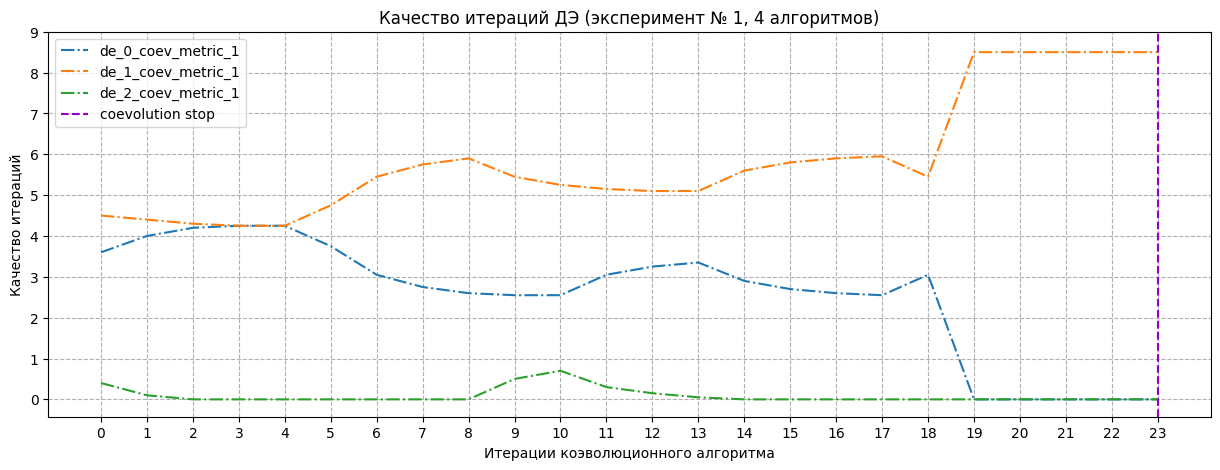

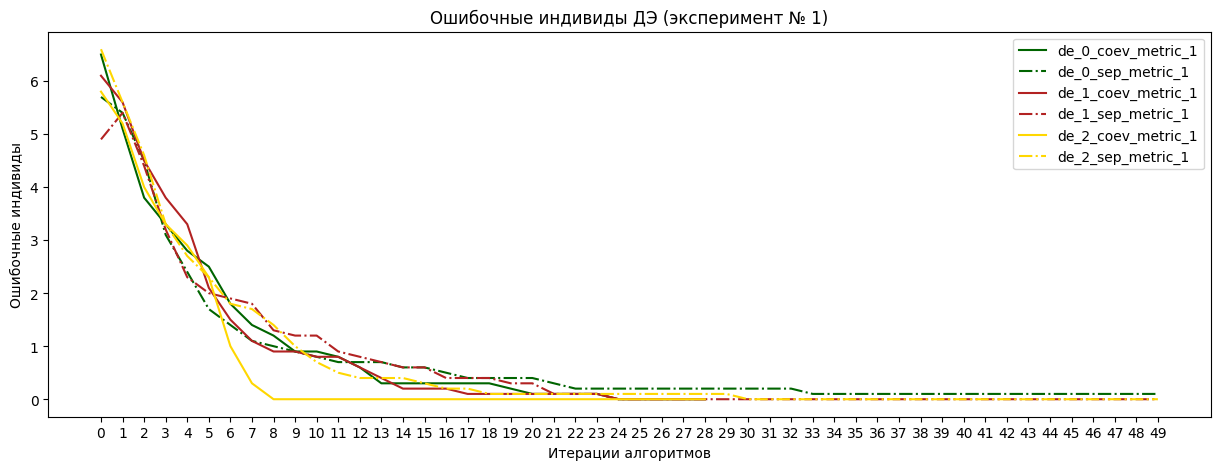


The global minimum is: 24.127115824561564
The global maximum is: 34.492187296564225

Algorithm de_0_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 28; 100% of population
Algorithm de_0_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_1_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 28; 100% of population
Algorithm de_1_sep_metric_1
	Values best+1%: 3; 6% of population
	Values between best+1% and best+5%: 11; 22% of population
	Values greater than best+5%: 35; 71% of population
Algorithm de_2_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 28; 100% of population
Algorithm de_2_sep_metric_1
	Values

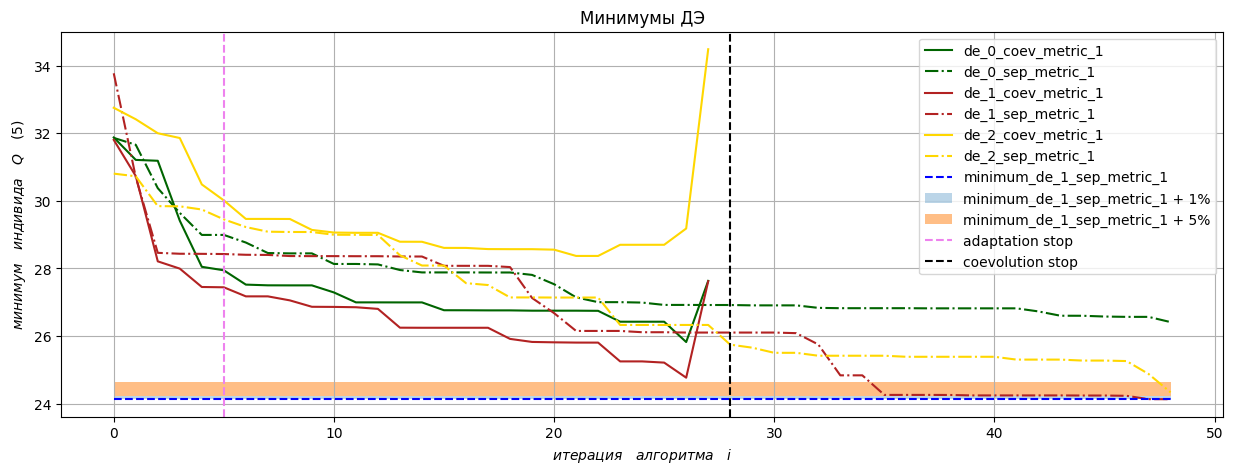

Популярность решений:
--- ('...', 7)
--- ('....', 6)
--- ('....{0,1}', 4)
--- ('()\\{0,1}', 1)
--- ('([0-9])\\{0,1}.', 1)
--- ('(\\[0-9])\\(', 1)
--- ('(\\{0,1}b.)', 1)
--- ('.().b{0,1}.', 1)
--- ('.(.)..', 1)
--- ('.(.)..{0,1}', 1)
--- ('.(\\[0-9]).', 1)
--- ('..().', 1)
--- ('...()', 1)
--- ('...|[0-9]', 1)
--- ('..b.{0,1}', 1)
--- ('..c.()', 1)
--- ('..cd', 1)
--- ('..{0,1}..', 1)
--- ('.b\\[0-9]().', 1)
--- ('[0-9].\\{0,1}().', 1)
--- ('\\[0-9]()', 1)
--- ('\\[0-9]{0,1}.[0-9]', 1)
--- ('\\{0,1}([0-9][0-9].)', 1)
--- ('c().b\\[0-9]', 1)
--- ('d.().', 1)
--- ('d.b.', 1)


In [83]:
minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db('0', 1)
get_qualities(qualities_metrics, exp_num=1, alg_num=4)
get_invalids(invalid_metrics, algorithm_num='1')
get_minimums(minimum_metrics, adaptation_interval=5)
get_popular_regexes(popular_regexes)

## Metric №2 - Precision

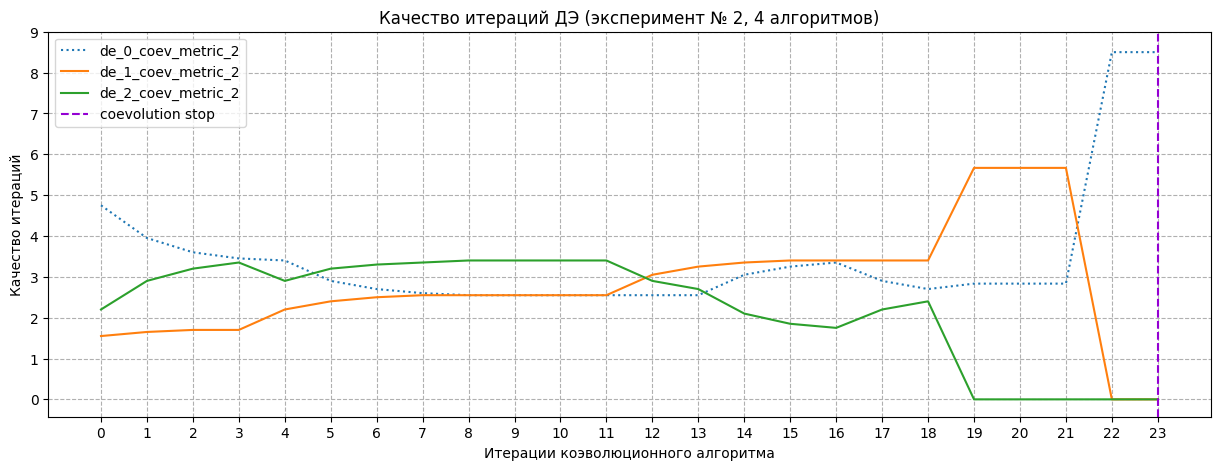

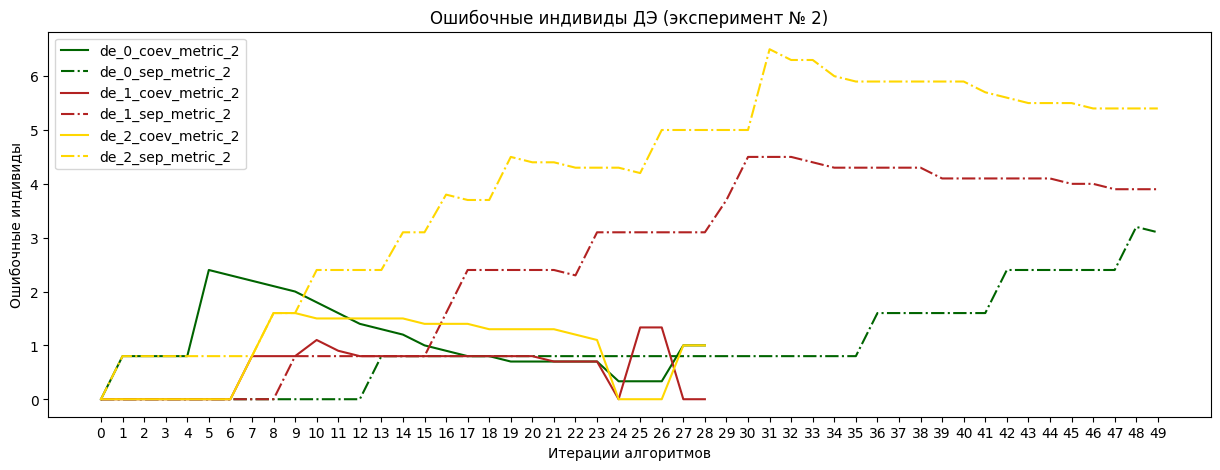


The global minimum is: 13.88246807685143
The global maximum is: 100000000000000.0

Algorithm de_0_coev_metric_2
	Values best+1%: 2; 7% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 26; 93% of population
Algorithm de_0_sep_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_1_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 28; 100% of population
Algorithm de_1_sep_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_2_coev_metric_2
	Values best+1%: 5; 18% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 82% of population
Algorithm de_2_sep_metric_2
	Values bes

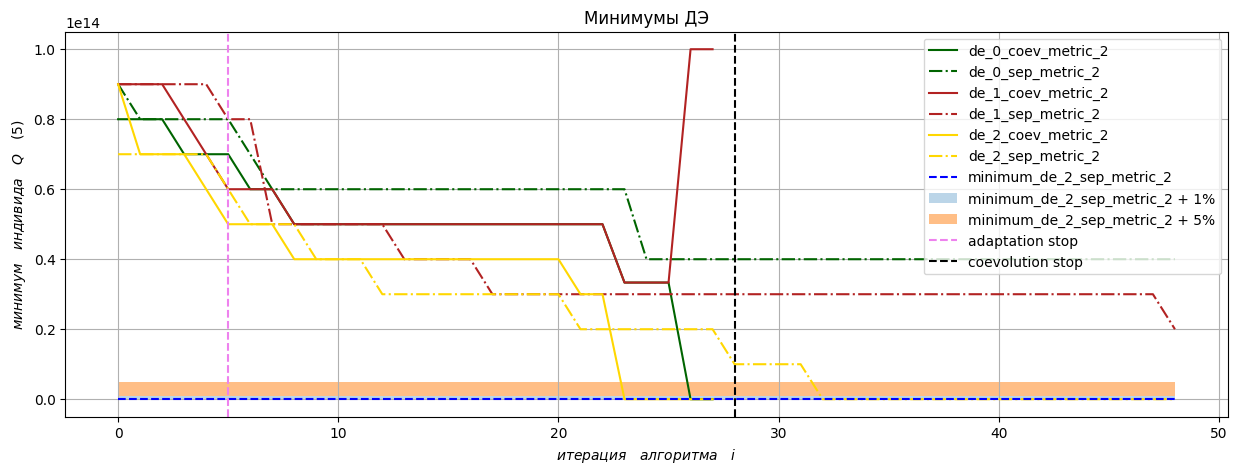

Популярность решений:
--- ('.c.', 4)
--- ('....', 2)
--- ('.b.', 2)
--- ('()..{0,1}.', 1)
--- ('(.)c.', 1)
--- ('(..)b.', 1)
--- ('(.b).', 1)
--- ('(.{0,1}c)..', 1)
--- ('(\\c({0,1}', 1)
--- ('.(.)..', 1)
--- ('.(.c).', 1)
--- ('.([0-9]|.).', 1)
--- ('..().', 1)
--- ('..().{0,1}', 1)
--- ('...().', 1)
--- ('...()d', 1)
--- ('....{0,1}', 1)
--- ('..b', 1)
--- ('..b.', 1)
--- ('..b..{0,1}', 1)
--- ('..c', 1)
--- ('..c.', 1)
--- ('.\\{0,1}{0,1}\\[0-9]', 1)
--- ('.b().', 1)
--- ('.bc().', 1)
--- ('.c..{0,1}', 1)
--- ('.c\\.{0,1}.{0,1}', 1)
--- ('[0-9]\\[0-9]{0,1}{0,1}', 1)
--- ('[0-9]{0,1}.c().', 1)
--- ('\\.[0-9]{0,1}\\', 1)
--- ('\\[0-9].\\{0,1}', 1)
--- ('c\\{0,1}b(', 1)
--- ('dc..', 1)
--- ('dcb', 1)
--- ('{0,1}(', 1)


In [84]:
minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db('0', 2)
get_qualities(qualities_metrics, exp_num=2, alg_num=4)
get_invalids(invalid_metrics, algorithm_num='2')
get_minimums(minimum_metrics, adaptation_interval=5)
get_popular_regexes(popular_regexes)

## Metric №3 - Recall

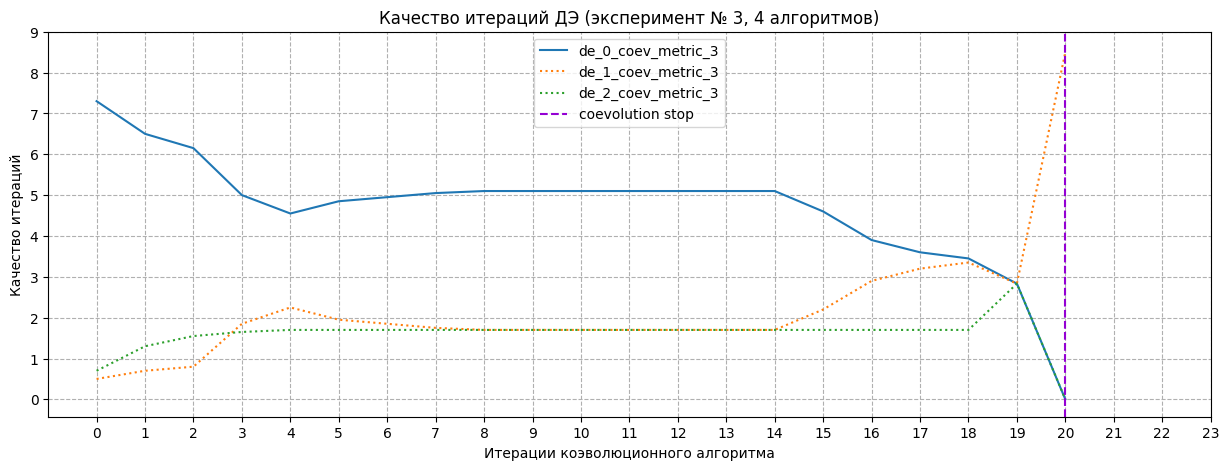

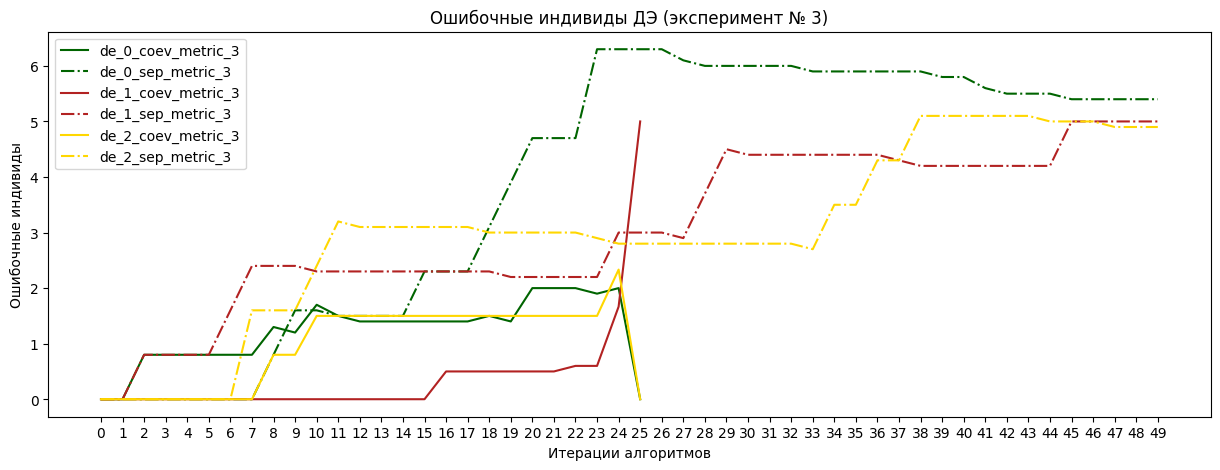


The global minimum is: 38.92620620047007
The global maximum is: 100000000000000.0

Algorithm de_0_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 100% of population
Algorithm de_0_sep_metric_3
	Values best+1%: 5; 10% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 44; 90% of population
Algorithm de_1_coev_metric_3
	Values best+1%: 1; 4% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 24; 96% of population
Algorithm de_1_sep_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_2_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 100% of population
Algorithm de_2_sep_metric_3
	Values bes

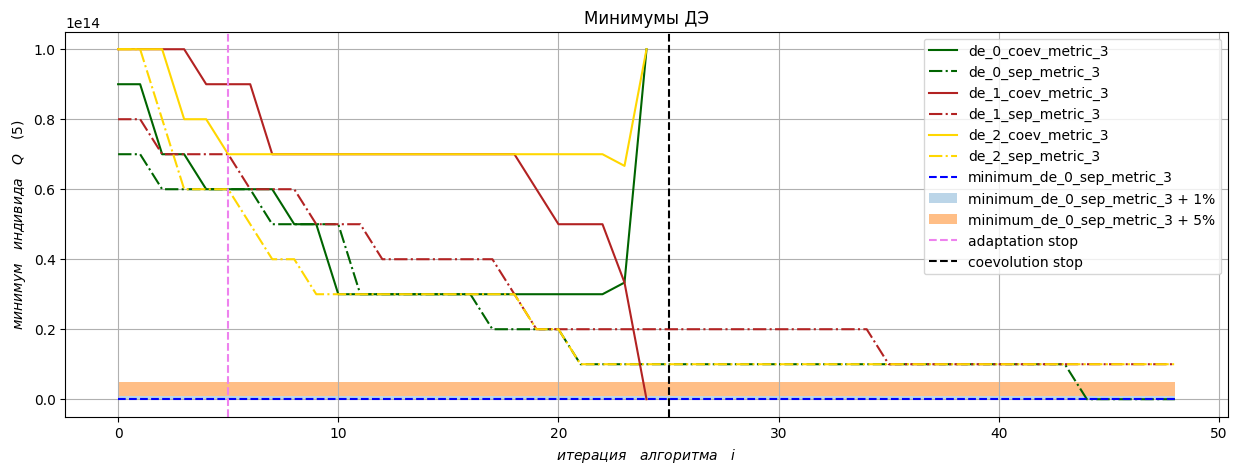

Популярность решений:
--- ('....{0,1}', 7)
--- ('....', 6)
--- ('...', 5)
--- ('.{0,1}...', 3)
--- ('..{0,1}.', 2)
--- ('..{0,1}..', 2)
--- ('((({0,1}).', 1)
--- ('()...', 1)
--- ('()..b[0-9]{0,1}.', 1)
--- ('(.).b.', 1)
--- ('(.{0,1}.)b', 1)
--- ('.(..).', 1)
--- ('..b', 1)
--- ('..{0,1}b{0,1}.', 1)
--- ('..{0,1}c.', 1)
--- ('.[0-9]{0,1}bc', 1)
--- ('.{0,1}..', 1)
--- ('\\c(\\', 1)
--- ('c{0,1}..b', 1)
--- ('d...', 1)
--- ('{0,1}b|\\{0,1}', 1)


In [85]:
minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db('0', 3)
get_qualities(qualities_metrics, exp_num=3, alg_num=4)
get_invalids(invalid_metrics, algorithm_num='3')
get_minimums(minimum_metrics, adaptation_interval=5)
get_popular_regexes(popular_regexes)

## Metric №4 - f1-score

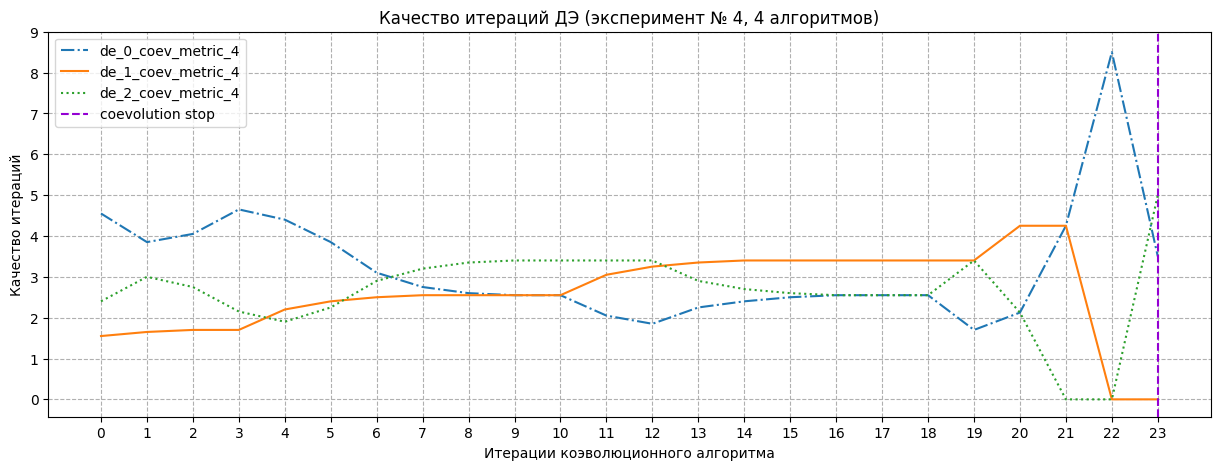

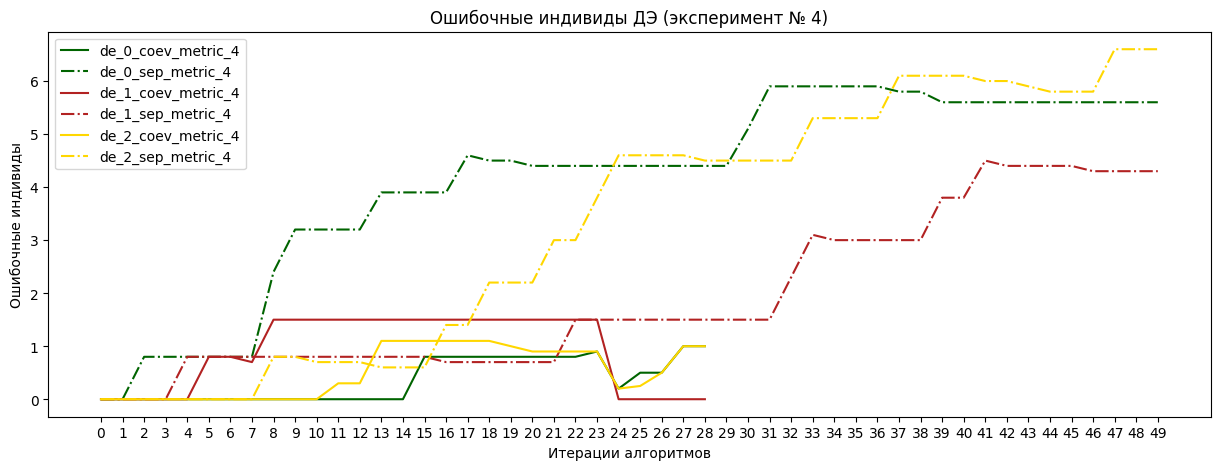


The global minimum is: 20.155159281693148
The global maximum is: 100000000000000.0

Algorithm de_0_coev_metric_4
	Values best+1%: 3; 11% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 89% of population
Algorithm de_0_sep_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_1_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 28; 100% of population
Algorithm de_1_sep_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm de_2_coev_metric_4
	Values best+1%: 3; 11% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 89% of population
Algorithm de_2_sep_metric_4
	Values b

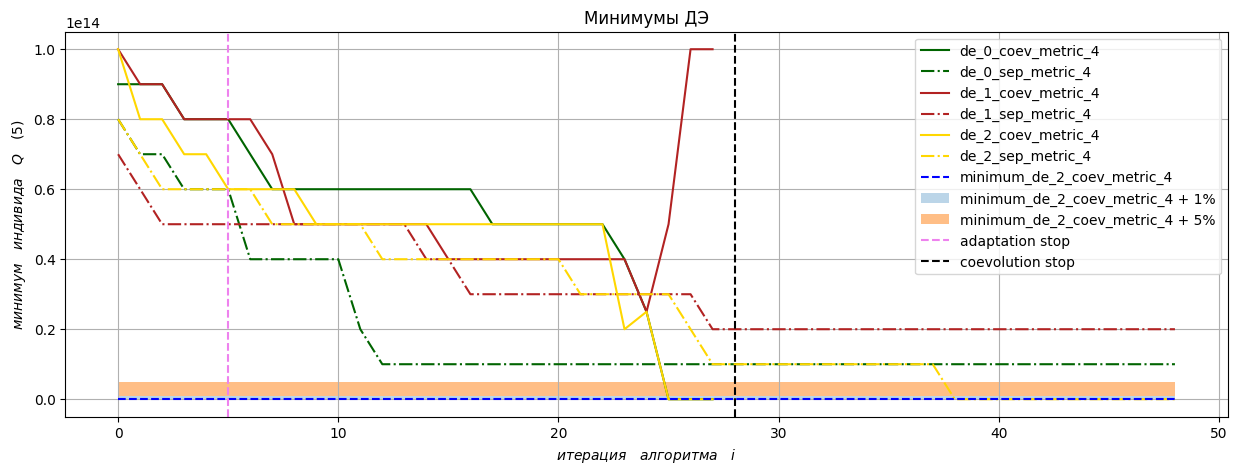

Популярность решений:
--- ('...', 6)
--- ('....', 6)
--- ('...{0,1}.', 3)
--- ('(....)', 2)
--- ('...()', 2)
--- ('..{0,1}..', 2)
--- ('(.)...', 1)
--- ('(...).', 1)
--- ('.(.).', 1)
--- ('.(..)', 1)
--- ('.(..).', 1)
--- ('..().{0,1}', 1)
--- ('...().', 1)
--- ('...{0,1}', 1)
--- ('..[0-9]|.(', 1)
--- ('..b', 1)
--- ('..b.', 1)
--- ('..{0,1}.', 1)
--- ('.b.', 1)
--- ('.c.', 1)
--- ('.{0,1}..', 1)
--- ('.{0,1}..(.)', 1)
--- ('[0-9]((().', 1)
--- ('[0-9].|', 1)
--- ('[0-9]|...', 1)


In [86]:
minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db('0', 4)
get_qualities(qualities_metrics, exp_num=4, alg_num=4)
get_invalids(invalid_metrics, algorithm_num='4')
get_minimums(minimum_metrics, adaptation_interval=5)
get_popular_regexes(popular_regexes)